# Early Stopping

If you peek at the results of an experiment before data collection is complete, and choose to stop early because the test is showing statistical significance, you run the risk of a significant increase in your Type I error rate: believing that your experiment had an effect, when in fact it did not. In this notebook, you'll duplicate the assertions made in the video: namely that for an experiment based off of a single traditional statistical test, doing a single peek halfway through the run-time will increase a base Type I error rate from 5% to about 8.6%.

In [1]:
import numpy as np
import scipy.stats as stats

The simulation function below uses a bernoulli / binomial success model for the outcome metric, measuring against a historic baseline. That is, each observation is a single coin flip with success probability "p". If we see a number of successes that is unusual for our baseline value of "p", then we declare a statistically significant result. We will divide the experiment length into multiple 'blocks', checking the status of the experiment after each block is complete. Our outputs of interest are the proportion of trials that are statistically significant in _any_ test, and the proportion of trials that are statistically significant after _each_ individual block.

There are three main steps to filling out the `peeking_sim()` function.

1. Simulate some data
 - Compute the number of trials per block. For simplicity, just round up any fractions so that each block has the same number of trials: we might end up with slightly more trials per block than the corresponding function parameter.
 - Generate a data matrix with the number of successes observed in each block: the number of rows should be the number of simulations and the number of columns the number of blocks. You can do this with a single call to numpy's [`random.binomial`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html) function.
2. Compute z-scores at each 'peek'
 - For each row, compute the cumulative number of successes after each 'block' of the experiment using numpy's [`cumsum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) function. The result should be a matrix with the same dimensions as the data, but each column cumulatively adds up the values in each row up to that point.
 - Compute the expected mean and standard deviation for the number of successes after each 'block' of the experiment. Remember that this will be based on the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) and is centered on the raw counts, rather than proportion of successes. It'll be useful to create a vector with the cumulative sum of trials after each block to facilitate these calculations.
 - Use the cumulative counts, the expected counts, and the standard deviations, to compute the z-scores for each peek at the experiment.
3. Aggregate test outcomes
 - Compute a critical z-value using the supposed Type I error rate. Use this critical value to flag which of the z-scores would be counted as statistically significant, and which would not.
 - The proportion of trials that are significant at _any_ test will be the proportion of rows that have at least one flagged value. The proportion of trials that are significant at _each_ block will be the mean number of flagged values in each column; this will be a 1-d array. Return both of these values as the output of the function.

In [ ]:
def peeking_sim(alpha = .05, p = .5, n_trials = 1_000, n_blocks = 2, n_sims = 10_000):
    """
    This function simulates the rate of Type I errors made if an early
    stopping decision is made based on a significant result when peeking ahead.
    
    Input parameters:
        alpha: Supposed Type I error rate
        p: Probability of individual trial success
        n_trials: Number of trials in a full experiment
        n_blocks: Number of times data is looked at (including end)
        n_sims: Number of simulated experiments run
        
    Return:
        p_sig_any: Proportion of simulations significant at any check point, 
        p_sig_each: Proportion of simulations significant at each check point
    """
    
    # generate data
    trials_per_block = np.ceil(n_trials / n_blocks).astype(int)
    data = np.random.binomial(trials_per_block, p, [n_sims, n_blocks])
    
    # standardize data
    data_cumsum = np.cumsum(data, axis = 1)
    block_sizes = trials_per_block * np.arange(1, n_blocks+1, 1)
    block_means = block_sizes * p
    block_sds   = np.sqrt(block_sizes * p * (1-p))
    data_zscores = (data_cumsum - block_means) / block_sds
    
    # test outcomes
    z_crit = stats.norm.ppf(1-alpha/2)
    sig_flags = np.abs(data_zscores) > z_crit
    p_sig_any = (sig_flags.sum(axis = 1) > 0).mean()
    p_sig_each = sig_flags.mean(axis = 0)
    
    return (p_sig_any, p_sig_each)
    

Running the function on the default parameters as given should return a tuple of results where the probability of any significant test outcome across the two blocks is around 8.6% and the probability of a significant test outcome at each individual block checkpoint is around 5%. Increase the number of trials and number of simulations to get more accurate estimates. You should also see how the overall Type I error rate increases with additional peeks!

In [3]:
peeking_sim(n_trials = 10_000, n_sims = 100_000)

(0.0832, array([0.04998, 0.05054]))

## A Multiple Comparisons Approach to Early Peeking

The safest way we could deal with performing multiple checks and making poor early stopping decisions is to simply not do it. Once an experiment has been planned and all assignment procedures checked, you should just let the experiment run to completion and just assess the results at the very end. That's not to say that you can't perform early stopping, but it does require additional planning.

One way in which you could solve for multiple peeking is to adjust the significance level of individual tests so that the overall error rate is at its desired level. But applying the Bonferroni or Šidák corrections as shown earlier in the lesson will definitely be too conservative, since we know that there is a correlation in test results between peeks. If we see some simulated run with z-score above the threshold at the halfway point, it's more likely to be above that threshold at the end point, compared to some other simulated run that is not statistically significant at the halfway point. One way in which we can obtain a better significance threshold is through the power of simulation. After performing the same steps 1 and 2 above, we want to find a significance level that would call our desired proportion of simulated tests as statistically significant:

1. Simulate some data (as above)
2. Compute z-scores at each 'peek' (as above)
3. Obtain required individual-test error rate
  - A run is considered statistically significant if it exceeds the critical bounds at _any_ peek. Obtain the maximum z-score from each row as a worst-case scenario for a null run to be falsely rejected.
  - Find the z-score threshold that would reject our desired overall Type I error rate.
  - Convert that z-score into an equivalent individual-test error rate.

In [4]:
def peeking_correction(alpha = .05, p = .5, n_trials = 1000, n_blocks = 2, n_sims = 10000):
    """
    This function uses simulations to estimate the individual error rate necessary
    to limit the Type I error rate, if an early stopping decision is made based on
    a significant result when peeking ahead.
    
    Input parameters:
        alpha: Desired overall Type I error rate
        p: Probability of individual trial success
        n_trials: Number of trials in a full experiment
        n_blocks: Number of times data is looked at (including end)
        n_sims: Number of simulated experiments run
        
    Return:
        alpha_ind: Individual error rate required to achieve overall error rate
    """
    
    # generate data
    trials_per_block = np.ceil(n_trials / n_blocks).astype(int)
    data = np.random.binomial(trials_per_block, p, [n_sims, n_blocks])
    
    # standardize data
    data_cumsum = np.cumsum(data, axis = 1)
    block_sizes = trials_per_block * np.arange(1, n_blocks+1, 1)
    block_means = block_sizes * p
    block_sds   = np.sqrt(block_sizes * p * (1-p))
    data_zscores = (data_cumsum - block_means) / block_sds
    
    # find necessary individual error rate
    max_zscores = np.abs(data_zscores).max(axis = 1)
    z_crit_ind = np.percentile(max_zscores, 100 * (1 - alpha))
    alpha_ind = 2 * (1 - stats.norm.cdf(z_crit_ind))
    
    return alpha_ind

Running the function on the default parameters should give a required individual error rate of about .029. Note how this is somewhat higher than the .025 or .0253 that would have been generated from the Bonferroni and Šidák corrections, respectively. Test with a higher number of simulations and trials to get more accurate estimates, and try out different numbers of blocks to see how it changes the individual error rate needed. The results should approximately match up with the numbers given in the table in the middle of [this article](https://www.evanmiller.org/how-not-to-run-an-ab-test.html); note that peeking $n$ times means splitting the experiment into $n + 1$ blocks.

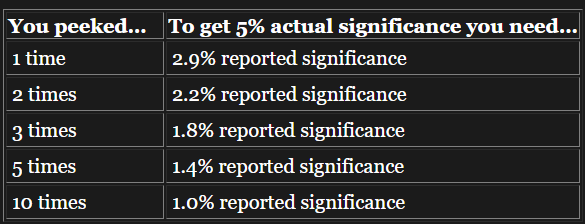

In [5]:
peeking_correction(n_trials = 10_000, n_sims = 100_000)

0.029257461551978503